# **Projeto 3 introdução a redes neurais - Autoencoders Variacionais (VAE)**

-------------------------------------------------------------------------------------------------------------

## Objetivo: 

Treinar modelos Variational Autoencoders (VAEs) em dois datasets rotulados, ajustando a topologia com base na função de custo. Explorar o espaço latente com projeção 2D , avaliando a formação de clusters, separação dos rótulos e variância explicada. Além disso, investigar a possibilidade de enviesar a formação do espaço latente com os rótulos.

## Importando bibliotecas necessárias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tensorflow import keras
from sklearn.manifold import TSNE
# Configuração do Searborn
sns.set(
    style='darkgrid',
    context='notebook',
    rc={
        'axes.spines.top': False,
        'axes.spines.right': False
    }
)

## Primeiro Dataset

O primeiro dataset utilizado é o **MNIST (Modified National Institute of Standards and Technology)**, ele contém 70.000 imagens em escala de cinza, com tamanho de 28x28 pixels, representando dígitos manuscritos de 0 a 9. O dataset é dividido em 60.000 imagens de treinamento e 10.000 de teste.

## Preparação dos dados

#### 1. Normalização das Imagens  
- Os pixels originalmente variam de **0 a 255**.  
- Para melhorar a estabilidade do modelo, os valores são convertidos para **o intervalo [0,1]**, usando divisão por 255.  

#### 2. Separação dos Conjuntos  
- Para avaliar o desempenho do modelo antes do teste, **separamos 5.000 imagens do treino para validação**.  
- Distribuição final dos dados:  
  - **Treino:** 55.000 imagens  
  - **Validação:** 5.000 imagens  
  - **Teste:** 10.000 imagens  

#### 3. Visualização dos Dados  
- São exibidas **10 imagens do conjunto de treino** com seus respectivos rótulos.  
- Isso permite verificar a qualidade e distribuição dos dados antes do treinamento.  

Tamanho do treino: (55000, 28, 28), (55000,)
Tamanho da validação: (5000, 28, 28), (5000,)
Tamanho do teste: (10000, 28, 28), (10000,)


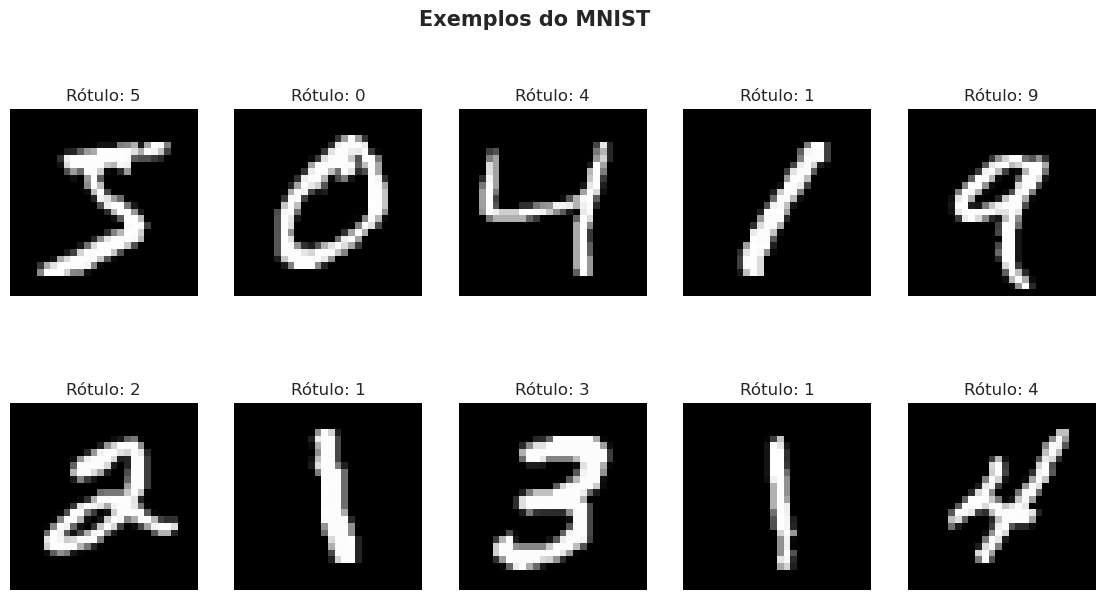

In [3]:
# Carregar o dataset MNIST
(X_treino, y_treino), (X_teste, y_teste) = keras.datasets.mnist.load_data()

# Normalizar os pixels (0-255 → 0-1) e converter para float32
X_treino = X_treino.astype(np.float32) / 255.
X_teste = X_teste.astype(np.float32) / 255.

# Separar treino e validação (55.000 para treino, 5.000 para validação)
X_treino, X_validacao = X_treino[:-5000], X_treino[-5000:]
y_treino, y_validacao = y_treino[:-5000], y_treino[-5000:]

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do treino: {X_treino.shape}, {y_treino.shape}")
print(f"Tamanho da validação: {X_validacao.shape}, {y_validacao.shape}")
print(f"Tamanho do teste: {X_teste.shape}, {y_teste.shape}")

# Plotar exemplos do dataset
plot, i = plt.subplots(2, 5, figsize=(14, 7))
plot.suptitle("Exemplos do MNIST", fontsize=15, fontweight='bold')

for i, ax in enumerate(i.flat):
    ax.imshow(X_treino[i], cmap="gray")
    ax.set_title(f"Rótulo: {y_treino[i]}")
    ax.axis("off")

## **Autoencoders Variacionais (VAE)**

### Modelos generativos 

Os modelos generativos, como o Variational Autoencoder (VAE), geram novos dados a partir do conhecimento extraído de um conjunto inicial. Ao contrário dos modelos discriminativos, que modelam a probabilidade condicional $P(Y|X)$, os modelos generativos como o VAE modelam a distribuição conjunta $P(X,Y)$, aprendendo a estrutura subjacente dos dados e usandp essa informação para criar novos exemplos semelhantes. 

O VAE impõe uma estrutura probabilística no espaço latente, garantindo que ele siga uma distribuição específica, como uma normal. Isso permite a geração de novos dados realistas a partir da amostragem nesse espaço latente.

Aplicações do VAE incluem geração de imagens, síntese de fala, geração de música, criação de novas moléculas e transferência de estilo, entre outras, ao criar dados sintéticos a partir da distribuição aprendida.


### Autoencoders 

Os autoencoders são redes neurais em sua forma padrão, geralmente compostas por uma rede neural de perceptrons multicamadas (MLP). Eles são divididos em duas partes principais: o codificador (encoder) e o decodificador (decoder). 

Os autoencoders são modelos não supervisionados, ou seja, treinam sem rótulos, com o objetivo de aprender uma representação compacta dos dados. A principal característica é que as saídas do modelo são iguais às entradas, o que os torna também conhecidos como modelos auto-supervisionados.

Durante o treinamento, o codificador mapeia a entrada $x$ para um espaço latente $z$, que é uma representação compacta das características mais importantes dos dados. O decodificador então reconstrói a entrada $x$ a partir dessa representação latente $z$. A função de perda é dada por:


de perda é dada por: $$\text{loss} = | x - d(e(x)) |^2$$

onde $x$ representa a entrada, $e(x)$ é a codificação gerada pelo codificador, e $d(e(x))$ é a reconstrução da entrada pelo decodificador. O objetivo é minimizar essa diferença, fazendo com que a reconstrução se aproxime o máximo possível dos dados originais.

### Autoencoder variacional

O Autoencoder Variacional (VAE) utiliza o espaço latente para gerar novos exemplos. Durante o treinamento, o encoder gera uma distribuição latente $p(z | x)$, e o decoder reconstrói a entrada $x$ a partir de amostras $z$ dessa distribuição. No entanto, se o modelo não for bem treinado, algumas regiões do espaço latente podem gerar exemplos inadequados.

O VAE é regularizado para evitar sobreajuste (overfitting) e garantir que o espaço latente seja contínuo e navegável. Isso permite a geração de novos exemplos de maneira coerente. A principal diferença em relação ao autoencoder padrão é que no VAE o encoder gera uma distribuição latente, e não uma única representação $z$.

A função de custo do VAE combina o erro de reconstrução e a divergência KL entre a distribuição latente e uma distribuição normal padrão $N(0, I)$. A função de perda é dada por:

$$
\text{loss} = \| x - d(e(x)) \|^2 + \text{KL}(N(\mu_x, \sigma_x), N(0, I))
$$

O objetivo é minimizar tanto o erro de reconstrução quanto a divergência KL para garantir um bom espaço latente para a geração de novos dados. 

### Divergência KL e reparametrização 

A divergência KL aproxima a distribuição latente $p(z|x)$ de uma normal padrão $N(0, I)$, garantindo um espaço latente contínuo e navegável. O truque de reparametrização reescreve a amostragem como  

$$
z = \mu_x + \sigma_x \cdot \epsilon, \quad \text{com } \epsilon \sim N(0, I),
$$  

permitindo a retropropagação e o ajuste diferenciável de $ \mu_x $ e $ \sigma_x $.


## Implementação

A biblioteca utilizada para implementar o VAE (Variational Autoencoder) neste projeto será o `TensorFlow (https://www.tensorflow.org)`, um framework amplamente utilizado para aprendizado profundo.

In [4]:
import tensorflow as tf # Importando o tensorflow 

### Classe VAE

Para facilitar a customização do modelo, uma classe foi criada para implementar um VAE (Autoencoder Variacional). Ela permite configurar o encoder e o decoder por meio de parâmetros personalizáveis. O encoder reduz a entrada para um espaço latente, onde são calculadas a média e a variância logarítmica, e aplica a reparametrização para amostrar o vetor latente. O decoder reconstrói a entrada a partir dessa representação latente. A classe oferece flexibilidade na escolha de camadas e configurações, além de incluir métodos para visualizar reconstruções e explorar o espaço latente com projeções 2D, o que facilita a análise dos resultados e a adaptação do modelo a diferentes necessidades.

In [5]:
# Camada de reparametrização
class Reparametrizacao(tf.keras.layers.Layer):
    """
    Camada para reparametrização do espaço latente:
    z = média + exp(log_var * 0.5) * epsilon
    """
    def call(self, entradas):
        media, log_var = entradas
        epsilon = tf.random.normal(tf.shape(log_var), dtype=tf.float32)  # Gera ruído aleatório
        return media + tf.exp(log_var / 2) * epsilon  # Aplica a reparametrização

# Classe VAE personalizável
class VAE(keras.Model):
    """
    Implementação de um Autoencoder Variacional (VAE) com camadas personalizáveis.
    
    O encoder reduz a entrada para um espaço latente de dimensão 'tamanho_latente',
    o decoder reconstrói a imagem original a partir da codificação latente,
    e a perda inclui um termo de reconstrução e a perda KL para regularização.
    """
    def __init__(self, entrada_dim=(28,28), tamanho_latente=16, peso_kl=0.001,
                 configuracao_encoder=None, configuracao_decoder=None, **kwargs):
        """
        Inicializa o modelo VAE.
        
        Parâmetros:
        - entrada_dim: Dimensões da entrada (altura, largura).
        - tamanho_latente: Dimensão do espaço latente.
        - peso_kl: Peso do termo de perda KL.
        - configuracao_encoder: Dicionário de configuração do encoder.
        - configuracao_decoder: Dicionário de configuração do decoder.
        """
        super(VAE, self).__init__(**kwargs)
        self.entrada_dim = entrada_dim
        self.tamanho_latente = tamanho_latente
        self.peso_kl = peso_kl
        self.reparametrizacao = Reparametrizacao()
        self.encoder_config = configuracao_encoder
        self.decoder_config = configuracao_decoder

        # Criação dos submodelos
        self.encoder = self._construir_encoder()
        self.decoder = self._construir_decoder()

    def _construir_encoder(self):
        """
        Constrói o encoder do VAE utilizando a configuração passada.
        O encoder aplica camadas convolucionais, max pooling e normalização,
        achata os dados e passa por uma camada densa para gerar os parâmetros
        da distribuição latente (média e log_variância).
        """
        entradas = keras.layers.Input(shape=self.entrada_dim, dtype=tf.float32)
        x = keras.layers.Reshape((*self.entrada_dim, 1))(entradas)  # Ajusta formato para convoluções

        # Adiciona camadas convolucionais conforme a configuração
        for camada in self.encoder_config['conv_layers']:
            x = keras.layers.Conv2D(filters=camada['filters'], kernel_size=camada['kernel_size'],
                                    padding='same', activation=camada['activation'])(x)
            x = keras.layers.MaxPool2D(pool_size=camada['pool_size'])(x)
            x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Flatten()(x)
        # Camada densa para reduzir a dimensão antes de calcular os parâmetros latentes
        x = keras.layers.Dense(self.encoder_config['dense_units'], activation='sigmoid')(x)
        
        # Calcula os parâmetros da distribuição latente
        media = keras.layers.Dense(self.tamanho_latente)(x)
        log_var = keras.layers.Dense(self.tamanho_latente)(x)
        # Aplica a reparametrização para obter o vetor latente
        codificacao = self.reparametrizacao([media, log_var])
        
        return keras.Model(inputs=entradas, outputs=[media, log_var, codificacao], name="encoder")

    def _construir_decoder(self):
        """
        Constrói o decoder do VAE utilizando a configuração passada.
        O decoder reconstrói a imagem original a partir do vetor latente através de
        uma camada densa que expande a dimensão, seguida de reshape e camadas de
        transposição convolucional e upsampling. A camada final usa ativação sigmoidal.
        """
        entradas = keras.layers.Input(shape=(self.tamanho_latente,), dtype=tf.float32)
        x = keras.layers.Dense(self.decoder_config['dense_units'])(entradas)
        x = keras.layers.Reshape((7, 7, 64))(x)
        
        # Adiciona camadas de transposição convolucional e upsampling conforme a configuração
        for camada in self.decoder_config['upsampling_layers']:
            x = keras.layers.Conv2DTranspose(filters=camada['filters'], kernel_size=camada['kernel_size'],
                                             padding='same', activation=camada['activation'])(x)
            x = keras.layers.UpSampling2D(size=camada['upsample'])(x)
            
        saida = keras.layers.Conv2DTranspose(filters=self.decoder_config['final_filters'],
                                             kernel_size=self.decoder_config['final_kernel_size'],
                                             padding='same', activation=self.decoder_config['final_activation'])(x)
        return keras.Model(inputs=entradas, outputs=saida, name="decoder")

    def _calcular_perda_kl(self, media, log_var):
        """
        Calcula a perda KL (Kullback-Leibler) para regularização do espaço latente.
        """
        perda_kl = -0.5 * tf.reduce_sum(1.0 + log_var - tf.exp(log_var) - tf.square(media), axis=-1)
        return self.peso_kl * tf.reduce_mean(perda_kl) / (np.prod(self.entrada_dim))

    def call(self, entradas):
        """
        Executa a passagem da entrada pelo modelo.
        Passa os dados pelo encoder para obter o vetor latente e os parâmetros da distribuição,
        e pelo decoder para reconstruir a imagem. Calcula e adiciona a perda KL.
        """
        media, log_var, codificacao = self.encoder(entradas)
        saida = self.decoder(codificacao)
        perda_kl = self._calcular_perda_kl(media, log_var)
        self.add_loss(perda_kl)
        return saida

    def reconstrucoes(self, imagens, n_imagens=10):
        """
        Plota as imagens originais e suas reconstruções.
        Para cada imagem, utiliza a função call para obter a reconstrução e plota em um gráfico.
        """
        reconstrucoes = []
        for i in range(n_imagens):
                        # Expande a dimensão para criar um batch de tamanho 1 e chama o modelo
            reconstrucoes.append(self.call(tf.expand_dims(imagens[i], axis=0)).numpy().squeeze())
        reconstrucoes = np.array(reconstrucoes)
        
        # Criação do gráfico com duas linhas: imagens originais e reconstruídas
        fig, axes = plt.subplots(2, n_imagens, figsize=(n_imagens * 1.5, 3))
        for i in range(n_imagens):
            axes[0, i].imshow(imagens[i], cmap="binary")
            axes[0, i].axis("off")
            axes[0, i].set_title("Original", fontsize=10)
            if i != n_imagens - 1:
                axes[0, i].spines['right'].set_linewidth(2)
                axes[0, i].spines['right'].set_color('gray')
            
            axes[1, i].imshow(reconstrucoes[i], cmap="binary")
            axes[1, i].axis("off")
            axes[1, i].set_title("Reconstrução", fontsize=10)
            if i != n_imagens - 1:
                axes[1, i].spines['left'].set_linewidth(2)
                axes[1, i].spines['left'].set_color('gray')
        
        plt.suptitle("Linha 1: Original | Linha 2: Reconstrução pelo VAE", fontsize=12)

    def plotar_espaco_latente_com_rotulos(self, X_val, y_val, X_test):
        """
        Gera a projeção 2D do espaço latente usando t-SNE e exibe os rótulos das amostras.
        Passa os dados pelo encoder para obter o vetor latente, aplica t-SNE para reduzir para 2D,
        normaliza as coordenadas e plota um gráfico de dispersão com as cores determinadas pelos rótulos.
        As imagens de cada amostra são exibidas no gráfico de dispersão.
        """
        # Obtem o vetor latente a partir dos dados de validação
        _, _, z_latente = self.encoder(X_val)
        
        # Aplica t-SNE para reduzir para 2D
        tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
        X_val_2D_tsne = tsne.fit_transform(z_latente)
        
        # Normaliza as coordenadas para o intervalo [0, 1]
        Z = (X_val_2D_tsne - X_val_2D_tsne.min()) / (X_val_2D_tsne.max() - X_val_2D_tsne.min())
        
        # Plota o gráfico de dispersão
        plt.figure(figsize=(10, 8))
        cmap = plt.cm.tab10
        plt.scatter(Z[:, 0], Z[:, 1], c=y_val, s=10, cmap=cmap)
        
        # Adiciona as imagens no gráfico
        image_positions = np.array([[1., 1.]])  # Inicia com uma posição fictícia
        for index, position in enumerate(Z):
            dist = ((position - image_positions) ** 2).sum(axis=1)
            if dist.min() > 0.02:  # Adiciona imagem se estiver suficientemente distante
                image_positions = np.r_[image_positions, [position]]
                imagebox = mpl.offsetbox.AnnotationBbox(
                    mpl.offsetbox.OffsetImage(X_test[index], cmap="binary"),
                    position, bboxprops={"edgecolor": cmap(y_val[index]), "lw": 2}
                )
                plt.gca().add_artist(imagebox)
        
        # Ajusta o gráfico
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title("Projeção 2D do Espaço Latente com t-SNE", fontsize=14, fontweight='bold')

### Primeiro modelo 

O primeiro modelo Variational Autoencoder (VAE) convolucional foi configurado para processar imagens 28x28 e aprender uma representação latente compacta. O encoder utiliza duas camadas convolucionais com 16 e 64 filtros, kernel 3x3 e ativação ReLU, seguidas por operações de *MaxPooling2D* e *BatchNormalization* para estabilizar o treinamento. O espaço latente tem dimensão 16, onde os parâmetros da distribuição latente são ajustados por meio das camadas *codings_mean* e *codings_log_var*. A amostragem é realizada utilizando a técnica de reparametrização.  

O decoder reconstrói as imagens a partir do vetor latente utilizando camadas densas e convolucionais transpostas (*Conv2DTranspose*), combinadas com operações de *UpSampling2D* para restaurar as dimensões espaciais. A camada final usa ativação sigmoidal para garantir que os valores da imagem reconstruída permaneçam entre 0 e 1. ALém disso o modelo será treinado por 30 épocas.

In [ ]:
# Configuração do primeiro encoder
primeiro_encoder = {
    'conv_layers': [
        {'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2},
        {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2}
    ],
    'dense_units': 30
}

# Configuração do segundo decoder 
primeiro_decoder = {
    'dense_units': 7 * 7 * 64,
    'upsampling_layers': [
        {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'upsample': 2},
        {'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'upsample': 2}
    ],
    'final_filters': 1,
    'final_kernel_size': 3,
    'final_activation': 'sigmoid'
}

# Instanciando o modelo VAE com entrada de 28x28 e espaço latente de dimensão 16
primeiro_vae = VAE(entrada_dim=(28, 28), tamanho_latente=16, peso_kl=0.001, configuracao_encoder=primeiro_encoder, configuracao_decoder=primeiro_decoder)
primeiro_vae.compile(loss="mse", optimizer="adam")

### Visualização do primeiro decoder e encoder

No modelo PrimeiroVAE, o TensorFlow permite visualizar a arquitetura do encoder e decoder utilizando a função `plot_model`. Isso ajuda a entender a estrutura do modelo, com o encoder codificando a entrada em um espaço latente e o decoder reconstruindo a imagem. Com o parâmetro `show_shapes=True`, é possível verificar os tamanhos dos tensores em cada camada, garantindo que as dimensões estejam corretas, o que é essencial para o bom funcionamento do VAE durante o treinamento.

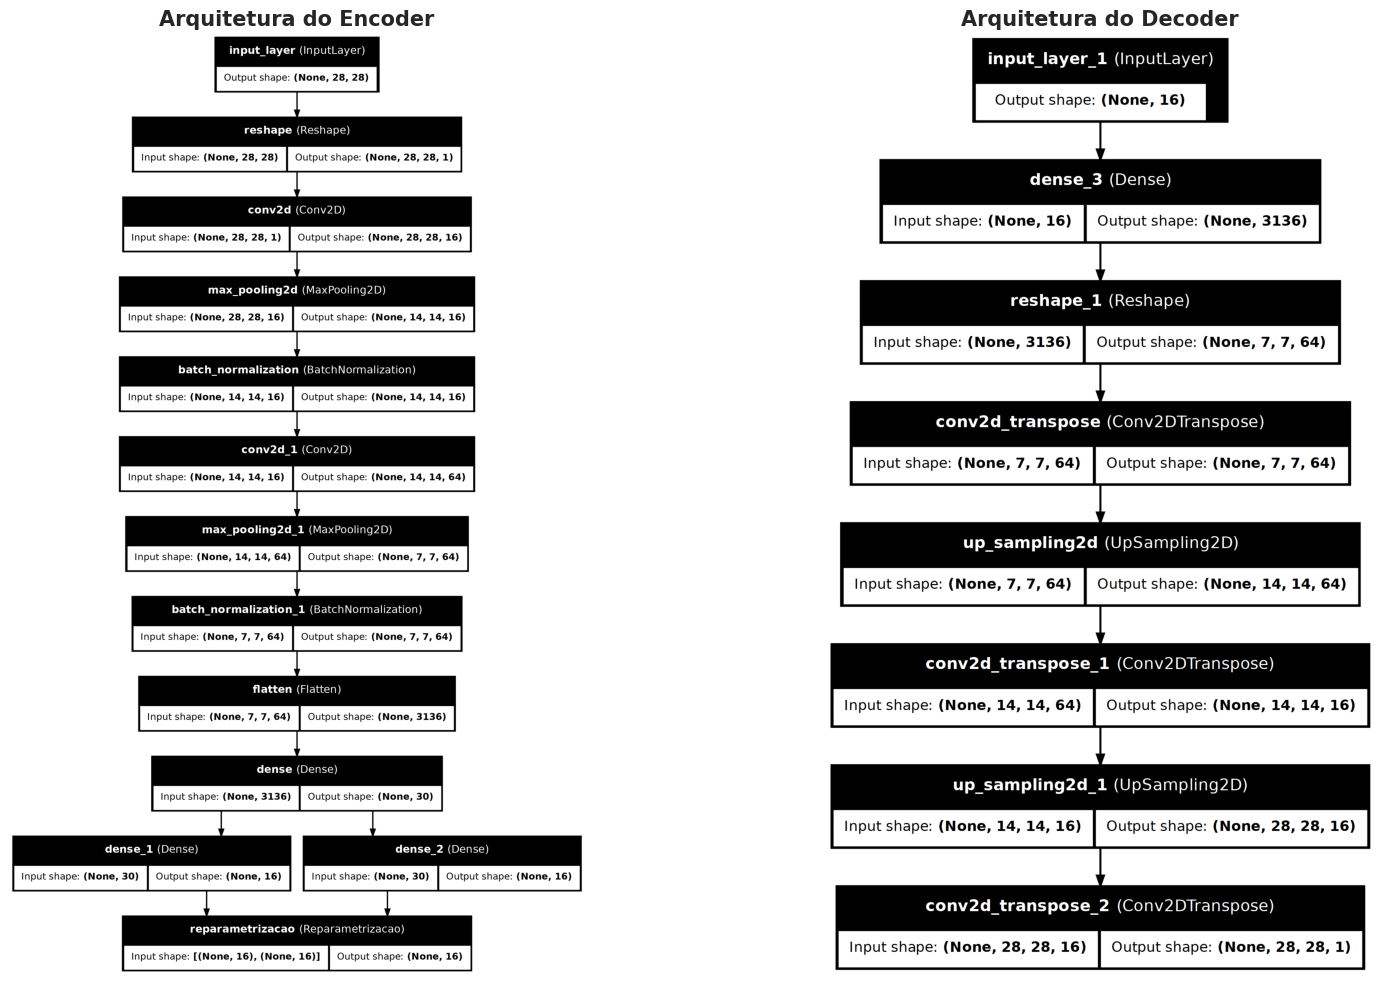

In [6]:
from keras.utils import plot_model

# Gera os diagramas dos modelos
plot_model(primeiro_vae.encoder, to_file="./imgs/encoder.png", show_shapes=True, show_layer_names=True)
plot_model(primeiro_vae.decoder, to_file="./imgs/decoder.png", show_shapes=True, show_layer_names=True)

# Carrega as imagens geradas
img_encoder = plt.imread("./imgs/encoder.png")
img_decoder = plt.imread("./imgs/decoder.png")

# Plota as imagens lado a lado
plot, i = plt.subplots(1, 2, figsize=(18, 10))
i[0].imshow(img_encoder)
i[0].set_title("Arquitetura do Encoder", fontsize=15, fontweight='bold')
i[0].axis("off")
i[1].imshow(img_decoder)
i[1].set_title("Arquitetura do Decoder", fontsize=15, fontweight='bold')
i[1].axis("off")

plt.tight_layout()

### Treinamento do primeiro modelo

In [7]:
# Checando GPU (opcional)
if tf.config.list_logical_devices('GPU'):
    print("Treinando com GPU disponível! :)")
else:
    print("GPU não detectada, usando CPU.")

Treinando com GPU disponível! :)


In [ ]:
# Treinar o primeiro modelo
primeiro_historico = primeiro_vae.fit(
    X_treino, X_treino,  # Usamos os dados de entrada também como targets (autoencoder)
    epochs=30,  # Número de épocas
    batch_size=128,  # Tamanho do batch
    validation_data=(X_validacao, X_validacao),  # Validação durante o treinamento
)

### Histórico de perda durante o treinamento do primeiro modelo

A perda durante o treinamento e validação do modelo mede o quão bem as previsões se ajustam aos dados reais, sendo calculada pela função de custo definida na compilação. No caso deste modelo, a perda utilizada é o erro quadrático médio (MSE), que quantifica a diferença entre os valores preditos e os reais, elevando ao quadrado os erros individuais para penalizar desvios maiores. A fórmula do MSE é dada por:  

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Durante o treinamento, espera-se que essa perda diminua, indicando que o modelo está aprendendo a reconstruir os dados de forma mais precisa. Se a perda de validação permanecer próxima à de treinamento, significa que o modelo generaliza bem sem overfitting.


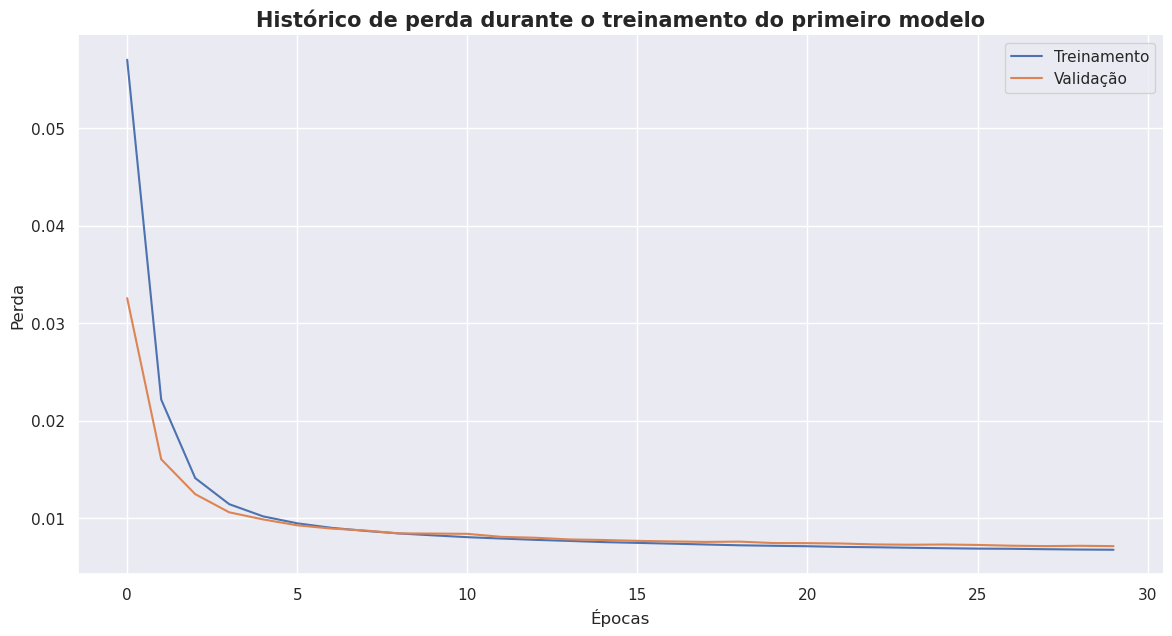

In [9]:
# Plotando o histórico de perda
plt.figure(figsize=(14,7))
plt.plot(primeiro_historico.history['loss'], label='Treinamento')
plt.plot(primeiro_historico.history['val_loss'], label='Validação')
plt.title('Histórico de perda durante o treinamento do primeiro modelo', fontsize=15, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

### Reconstrução VAE do primeiro modelo

A reconstrução no VAE começa com o encoder comprimindo a imagem em um espaço latente, gerando média e log da variância de uma distribuição probabilística. A camada de reparametrização amostra um vetor latente a partir desses parâmetros, que é passado ao decoder. O decoder reconstrói a imagem aplicando camadas convolucionais transpostas para recuperar sua estrutura original. Durante o treinamento, a perda de reconstrução mede a diferença entre a imagem original e a reconstruída, enquanto a perda KL regula o espaço latente, garantindo uma boa representação.

W0000 00:00:1738679993.808374   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.827657   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.829390   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.831055   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.832712   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.834392   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.836035   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.837683   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679993.839360   18573 gp

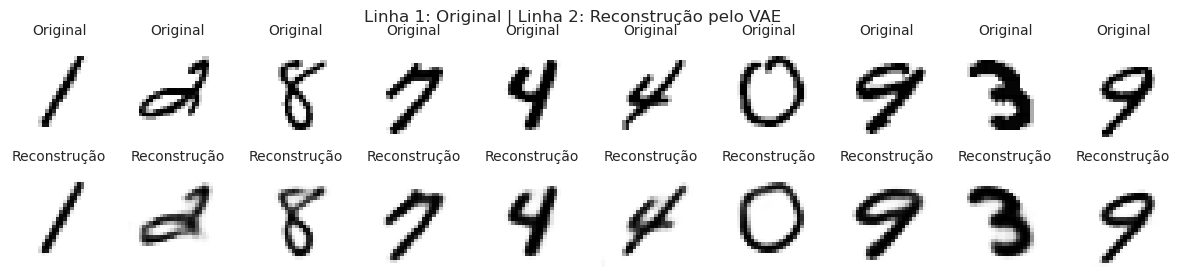

In [10]:
primeiro_vae.reconstrucoes(X_validacao, n_imagens=10)

### Visualização do espaço latente do primeiro modelo

O t-SNE (t-Distributed Stochastic Neighbor Embedding) é uma técnica de redução de dimensionalidade que transforma dados de alta dimensão em uma representação 2D ou 3D, preservando a proximidade dos pontos semelhantes. Ao aplicar t-SNE ao espaço latente de um modelo como o VAE, podemos visualizar como as amostras estão agrupadas no espaço aprendido, com base nas distâncias entre elas. Usando os rótulos das amostras, conseguimos observar a separação entre as classes. A adição das imagens no gráfico permite entender melhor como as amostras se distribuem no espaço latente.

W0000 00:00:1738679995.049514   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.056872   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.064229   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.071528   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.079169   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.097120   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.109792   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.121667   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738679995.134616   18573 gp

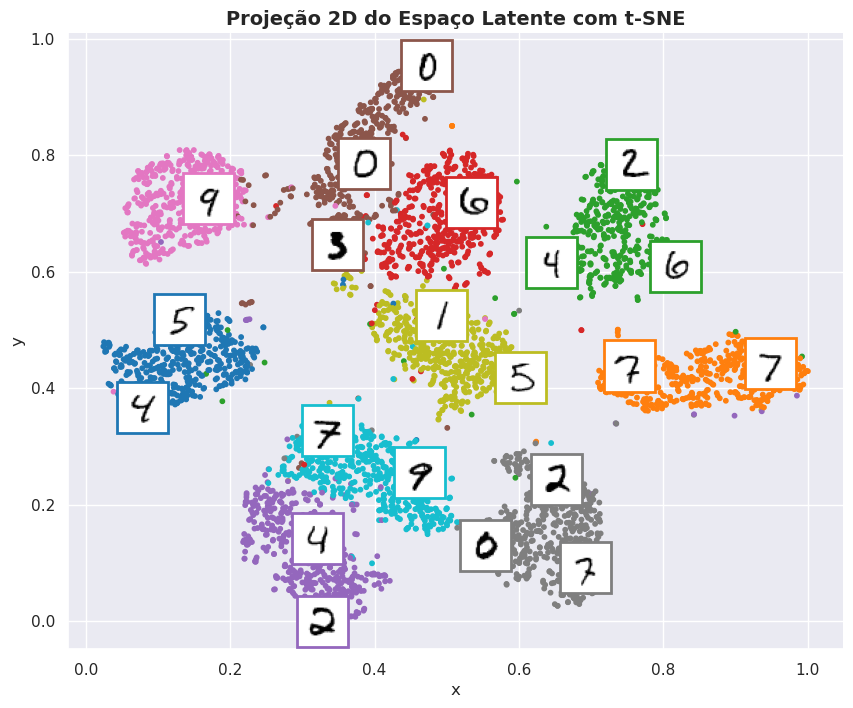

In [11]:
primeiro_vae.plotar_espaco_latente_com_rotulos(X_validacao, y_validacao, X_teste)

O primeiro modelo VAE configurado apresentou um desempenho satisfatório, com boas reconstruções das imagens, mas não de forma ótima. A qualidade das reconstruções ficou abaixo do esperado, com algumas perdas perceptíveis. O encoder conseguiu extrair informações essenciais, mas a configuração das camadas e o número de unidades na camada densa (30 unidades) podem ser insuficientes. O decoder gerou imagens razoáveis, mas poderia ser mais refinado. Além disso, na projeção 2D do espaço latente, alguns clusters não se separaram muito bem, indicando que o modelo não conseguiu capturar completamente as relações entre as classes. Ajustes nos hiperparâmetros e na arquitetura poderiam melhorar a fidelidade das reconstruções e a separação no espaço latente.

### Segundo modelo 


O segundo modelo VAE convolucional foi configurado para processar imagens de 28x28 pixels e aprender uma representação latente de dimensão 32, o dobro do primeiro modelo. O encoder possui quatro camadas convolucionais com filtros de 32 a 512, ativação ReLU, MaxPooling2D e BatchNormalization, ajustando a distribuição latente com codings_mean e codings_log_var. O decoder usa camadas densas, convolucionais transpostas e UpSampling2D para reconstruir as imagens. A camada final aplica uma ativação sigmoidal para garantir valores entre 0 e 1. O modelo foi treinado por 50 épocas para otimizar a reconstrução.

In [7]:
# Configuração do segundo encoder
segundo_encoder = {
    'conv_layers': [
        {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2},
        {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2},
        {'filters': 256, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2},
        {'filters': 512, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2}  
    ],
    'dense_units': 60
}

# Configuração do segundo decoder 
segundo_decoder = {
    'dense_units': 7 * 7 * 64, 
    'upsampling_layers': [
        {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'upsample': 2},
        {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'upsample': 2},
    ],
    'final_filters': 1,
    'final_kernel_size': 3,
    'final_activation': 'sigmoid'
}

# Instanciando o modelo VAE com entrada de 28x28 e espaço latente de dimensão 32
segundo_vae = VAE(entrada_dim=(28, 28), tamanho_latente=32, peso_kl=0.001, configuracao_encoder=segundo_encoder, configuracao_decoder=segundo_decoder)
segundo_vae.compile(loss="mse", optimizer="adam")

### Visualização do segundo decoder e encoder

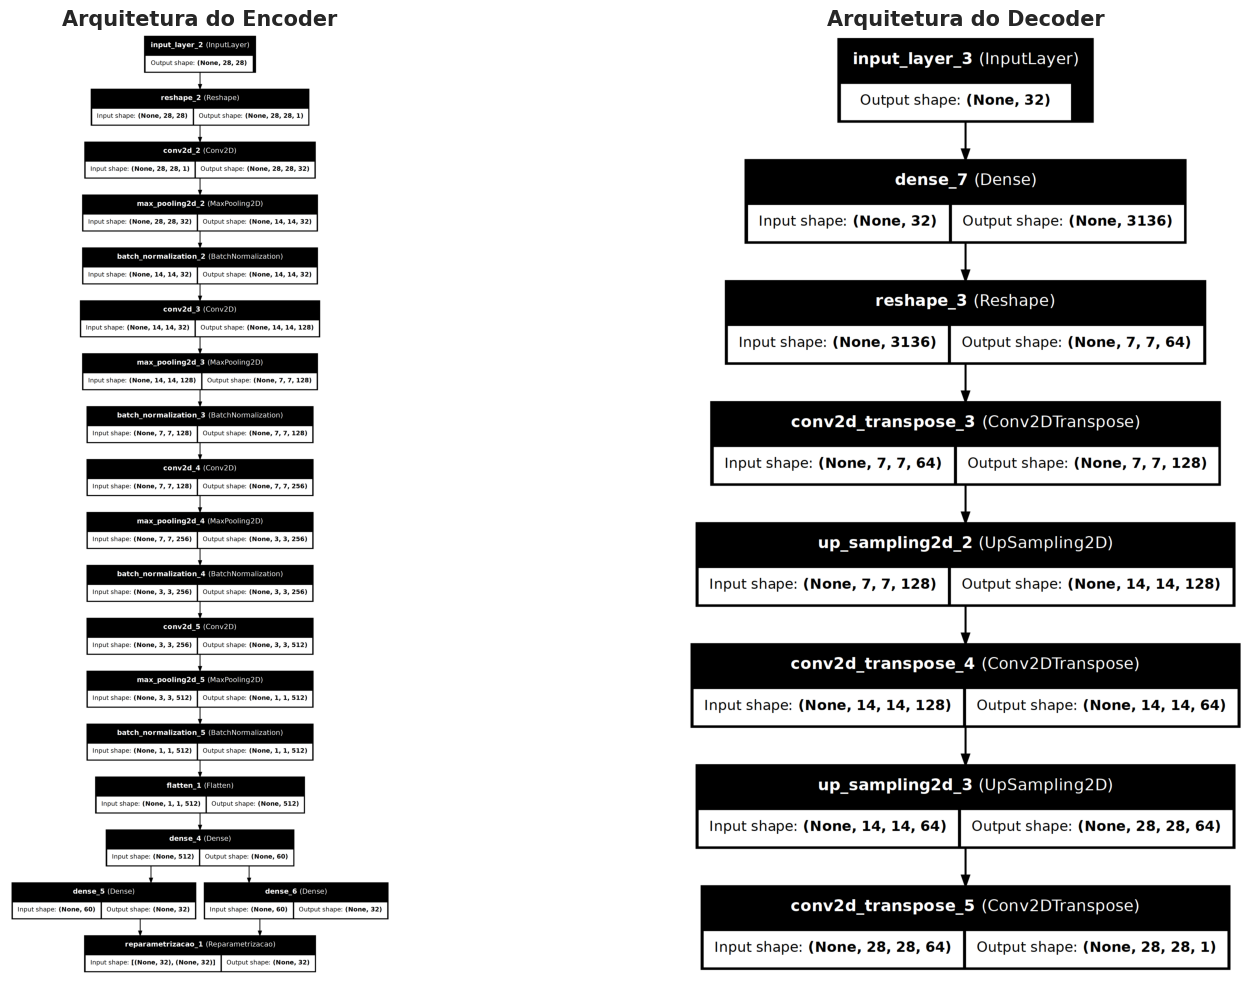

In [13]:
# Gera os diagramas dos modelos
plot_model(segundo_vae.encoder, to_file="./imgs/segundo_encoder.png", show_shapes=True, show_layer_names=True)
plot_model(segundo_vae.decoder, to_file="./imgs/segundo_decoder.png", show_shapes=True, show_layer_names=True)

# Carrega as imagens geradas
img_encoder_2 = plt.imread("./imgs/segundo_encoder.png")
img_decoder_2 = plt.imread("./imgs/segundo_decoder.png")

# Plota as imagens lado a lado
plot, i = plt.subplots(1, 2, figsize=(18, 10))
i[0].imshow(img_encoder_2)
i[0].set_title("Arquitetura do Encoder", fontsize=15, fontweight='bold')
i[0].axis("off")
i[1].imshow(img_decoder_2)
i[1].set_title("Arquitetura do Decoder", fontsize=15, fontweight='bold')
i[1].axis("off")

plt.tight_layout()

### Treinamento do segundo modelo

In [ ]:
# Treinar o segundo modelo
segundo_historico = segundo_vae.fit(
    X_treino, X_treino,  # Usamos os dados de entrada também como targets (autoencoder)
    epochs=50,  # Número de épocas 
    batch_size=128,  # Tamanho do batch
    validation_data=(X_validacao, X_validacao),  # Validação durante o treinamento
)

### Histórico de perda durante o treinamento do segundo modelo

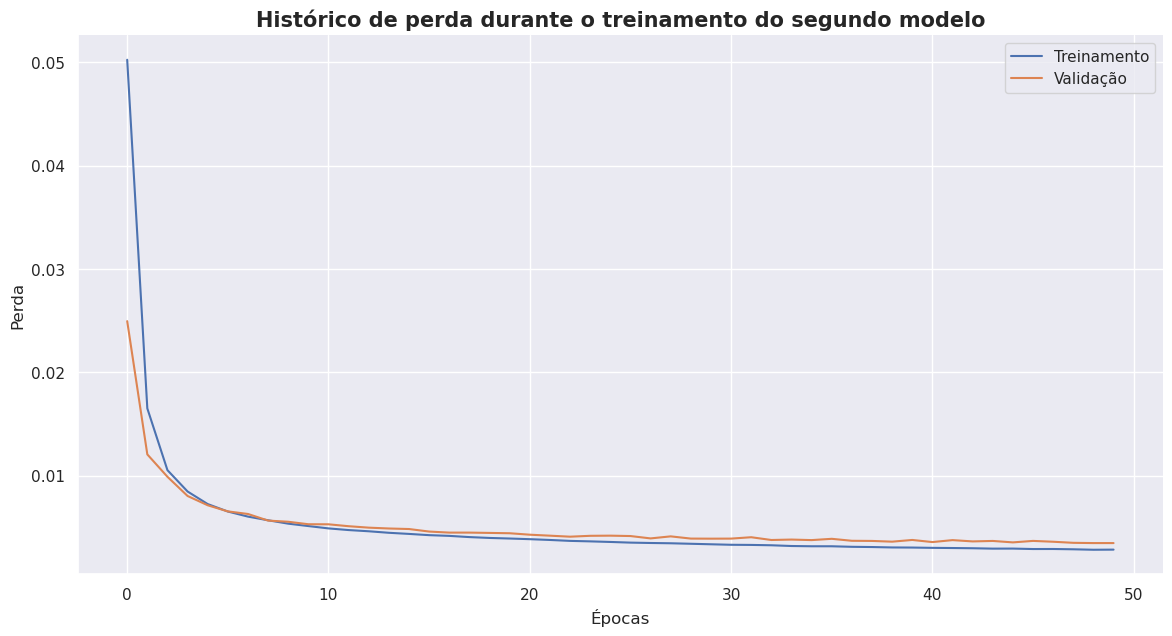

In [15]:
# Plotando o histórico de perda
plt.figure(figsize=(14,7))
plt.plot(segundo_historico.history['loss'], label='Treinamento')
plt.plot(segundo_historico.history['val_loss'], label='Validação')
plt.title('Histórico de perda durante o treinamento do segundo modelo', fontsize=15, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

### Reconstrução VAE do segundo modelo

W0000 00:00:1738681123.376038   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.377927   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.379772   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.381669   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.383557   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.385599   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.387725   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.389608   18573 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738681123.391459   18573 gp

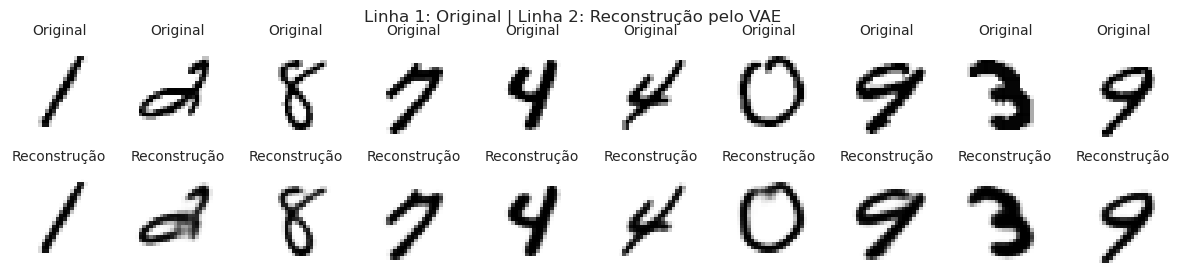

In [16]:
segundo_vae.reconstrucoes(X_validacao, n_imagens=10)

### Visualização do espaço latente do segundo modelo

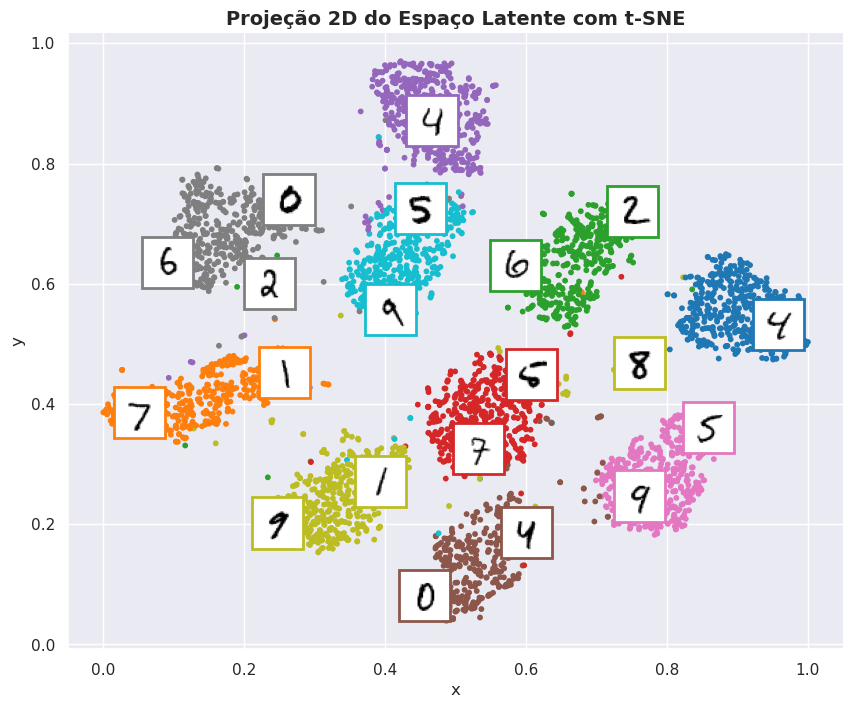

In [18]:
with tf.device('/CPU:0'): # Usando a cpu
    segundo_vae.plotar_espaco_latente_com_rotulos(X_validacao, y_validacao, X_teste)

O segundo modelo VAE configurado apresentou um desempenho significativamente superior ao primeiro, com uma melhoria notável tanto nas reconstruções das imagens quanto na separação do espaço latente. A qualidade das reconstruções foi muito mais refinada, com menos perdas perceptíveis, indicando uma capacidade maior de capturar as características essenciais das imagens. O encoder, agora com camadas convolucionais mais profundas e unidades densas aumentadas para 60, foi capaz de extrair informações mais ricas e complexas. O decoder, com camadas adicionais e mais filtros, gerou imagens com maior fidelidade e detalhes. Além disso, a projeção 2D do espaço latente mostrou uma separação mais clara entre os clusters, refletindo a melhor capacidade do modelo em entender e diferenciar as classes presentes no dataset. Esses avanços foram possíveis graças ao aumento da profundidade das camadas e ao maior número de neurônios, que permitiram ao modelo aprender representações mais robustas e precisas.

## Segundo Dataset

O segundo dataset utilizado é o Fashion MNIST. Ele contém 70.000 imagens em escala de cinza, com dimensões de 28x28 pixels, representando 10 categorias de roupas e acessórios. Os modelos VAE desenvolvidos anteriormente serão aplicados a esse novo dataset.

### Preparação dos dados 

 #### 1. Normalização das Imagens  
- Os pixels originalmente variam de **0 a 255**.  
- Para melhorar a estabilidade do modelo, os valores são convertidos para **o intervalo [0,1]**, usando divisão por 255.  

#### 2. Separação dos Conjuntos  
- Para avaliar o desempenho do modelo antes do teste, **separamos 5.000 imagens do treino para validação**.  
- Distribuição final dos dados:  
  - **Treino:** 55.000 imagens  
  - **Validação:** 5.000 imagens  
  - **Teste:** 10.000 imagens  

#### 3. Visualização dos Dados  
- São exibidas **10 imagens do conjunto de treino** com seus respectivos rótulos.  
- Isso permite verificar a qualidade e distribuição dos dados antes do treinamento. 

Tamanho do treino: (55000, 28, 28), (55000,)
Tamanho da validação: (5000, 28, 28), (5000,)
Tamanho do teste: (10000, 28, 28), (10000,)


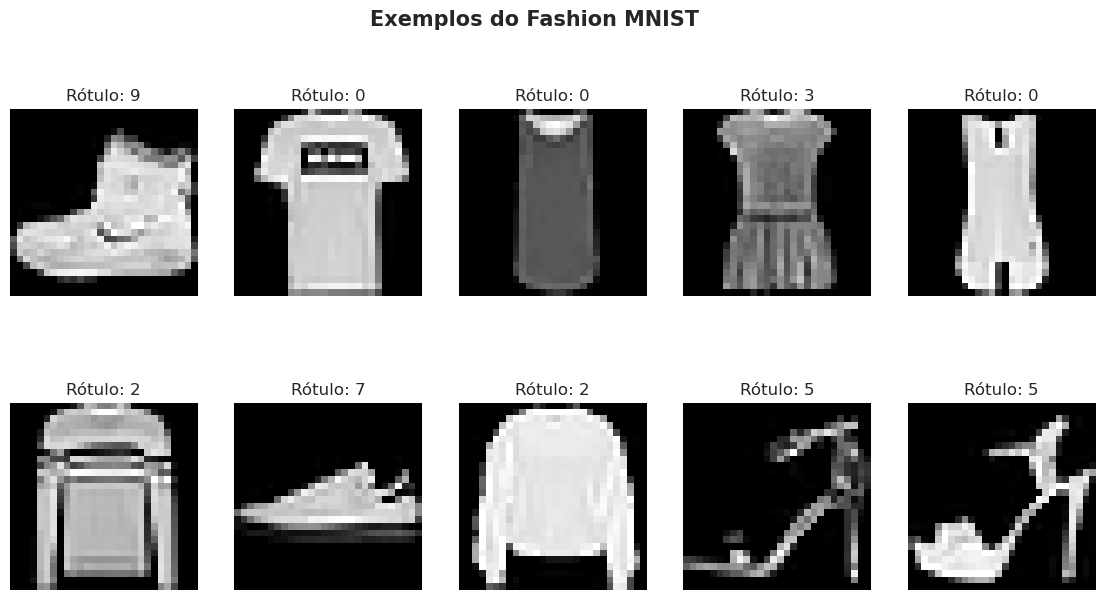

In [12]:
# Carregar o dataset Fashion MNIST
(X_treino_2, y_treino_2), (X_teste_2, y_teste_2) = keras.datasets.fashion_mnist.load_data()

# Normalizar os pixels (0-255 → 0-1) e converter para float32
X_treino_2 = X_treino_2.astype(np.float32) / 255.
X_teste_2 = X_teste_2.astype(np.float32) / 255.

# Separar treino e validação (55.000 para treino, 5.000 para validação)
X_treino_2, X_validacao_2 = X_treino_2[:-5000], X_treino_2[-5000:]
y_treino_2, y_validacao_2 = y_treino_2[:-5000], y_treino_2[-5000:]

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do treino: {X_treino_2.shape}, {y_treino_2.shape}")
print(f"Tamanho da validação: {X_validacao_2.shape}, {y_validacao_2.shape}")
print(f"Tamanho do teste: {X_teste_2.shape}, {y_teste_2.shape}")

plot, i = plt.subplots(2, 5, figsize=(14, 7))
plot.suptitle("Exemplos do Fashion MNIST", fontsize=15, fontweight='bold')

for i, j in enumerate(i.flat):
    j.imshow(X_treino_2[i], cmap="gray")
    j.set_title(f"Rótulo: {y_treino_2[i]}")
    j.axis("off")

### Aplicando o primeiro modelo VAE no segundo Dataset

In [ ]:
# Treinar o primeiro modelo no segundo dataset
terceiro_historico = primeiro_vae.fit(
    X_treino_2, X_treino_2,  # Usamos os dados de entrada também como targets (autoencoder)
    epochs=30,  # Número de épocas
    batch_size=128,  # Tamanho do batch
    validation_data=(X_validacao_2, X_validacao_2),  # Validação durante o treinamento
)

### Histórico de perda durante o treinamento do primeiro modelo no segundo dataset

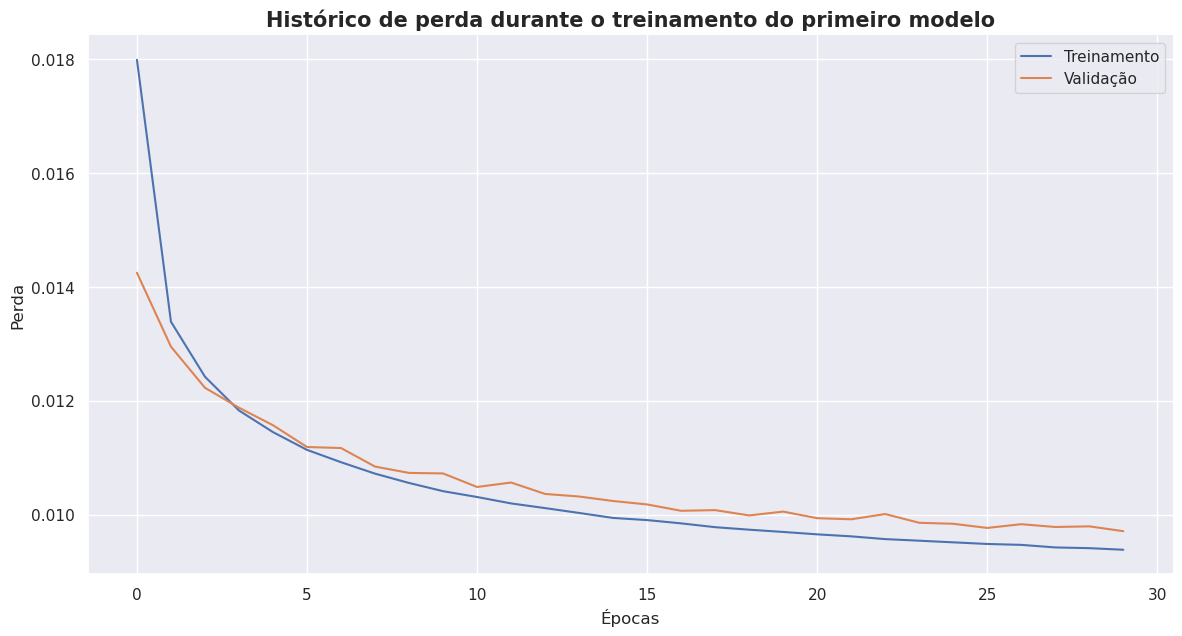

In [21]:
# Plotando o histórico de perda
plt.figure(figsize=(14,7))
plt.plot(terceiro_historico.history['loss'], label='Treinamento')
plt.plot(terceiro_historico.history['val_loss'], label='Validação')
plt.title('Histórico de perda durante o treinamento do primeiro modelo', fontsize=15, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

### Reconstrução VAE do primeiro modelo no segundo dataset

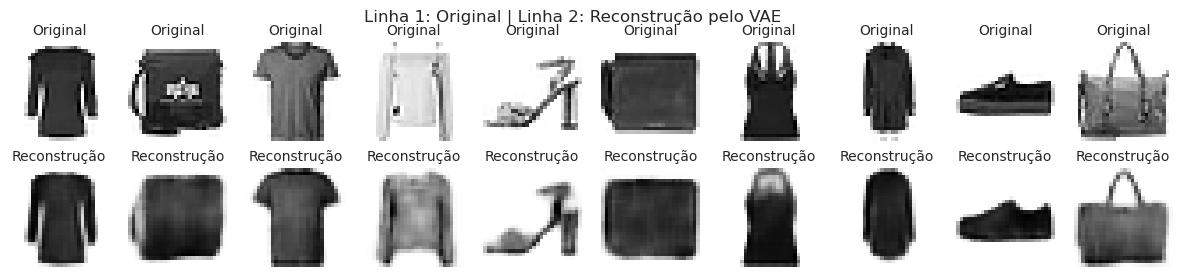

In [22]:
primeiro_vae.reconstrucoes(X_validacao_2, n_imagens=10)

### Visualização do espaço latente do primeiro modelo no segundo dataset

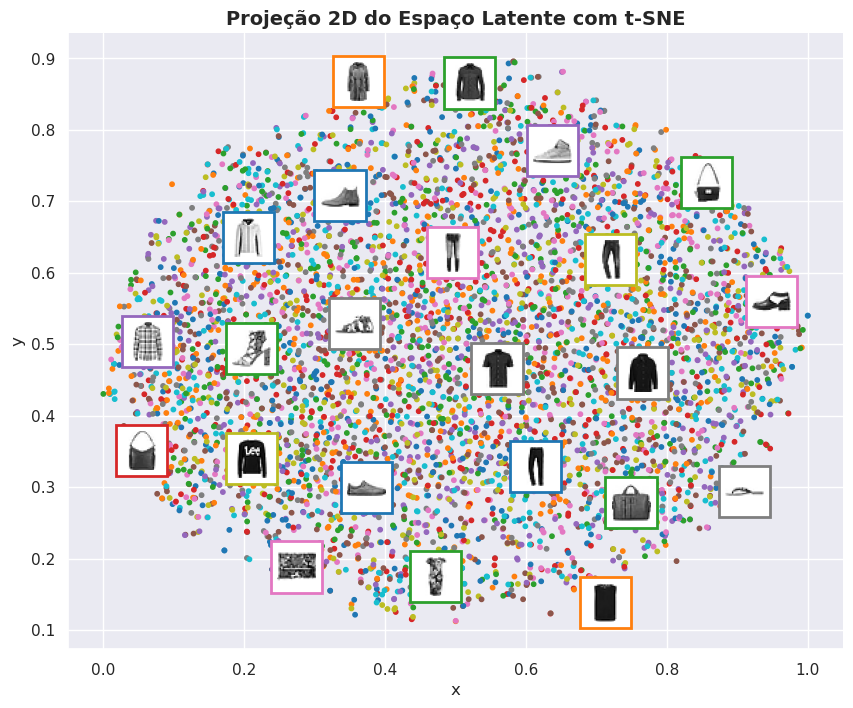

In [10]:
with tf.device('/CPU:0'): # Usando a cpu
    primeiro_vae.plotar_espaco_latente_com_rotulos(X_validacao_2, y_validacao_2, X_teste_2)

O primeiro modelo no segundo dataset não apresentou um desempenho satisfatório. Dado que o Fashion MNIST é um dataset mais complexo, com imagens de roupas e acessórios, as reconstruções não foram muito boas e apresentaram algumas distorções perceptíveis. A separação dos clusters no espaço latente também não foi ideal, com as diferentes classes se sobrepondo de forma visível. Embora o encoder tenha sido capaz de capturar algumas características das imagens, a arquitetura do modelo e o número de unidades na camada densa podem não ter sido adequados para a complexidade dos dados. A qualidade das reconstruções e a separação das classes no espaço latente indicam que ajustes nos hiperparâmetros e melhorias na arquitetura são necessários para alcançar um desempenho melhor e mais refinado.

### Aplicando o segundo modelo VAE no segundo Dataset

In [ ]:
# Treinar o segundo modelo
quarto_historico = segundo_vae.fit(
    X_treino_2, X_treino_2,  # Usamos os dados de entrada também como targets (autoencoder)
    epochs=50,  # Número de épocas 
    batch_size=128,  # Tamanho do batch
    validation_data=(X_validacao_2, X_validacao_2),  # Validação durante o treinamento
)

### Histórico de perda durante o treinamento do segundo modelo no segundo dataset

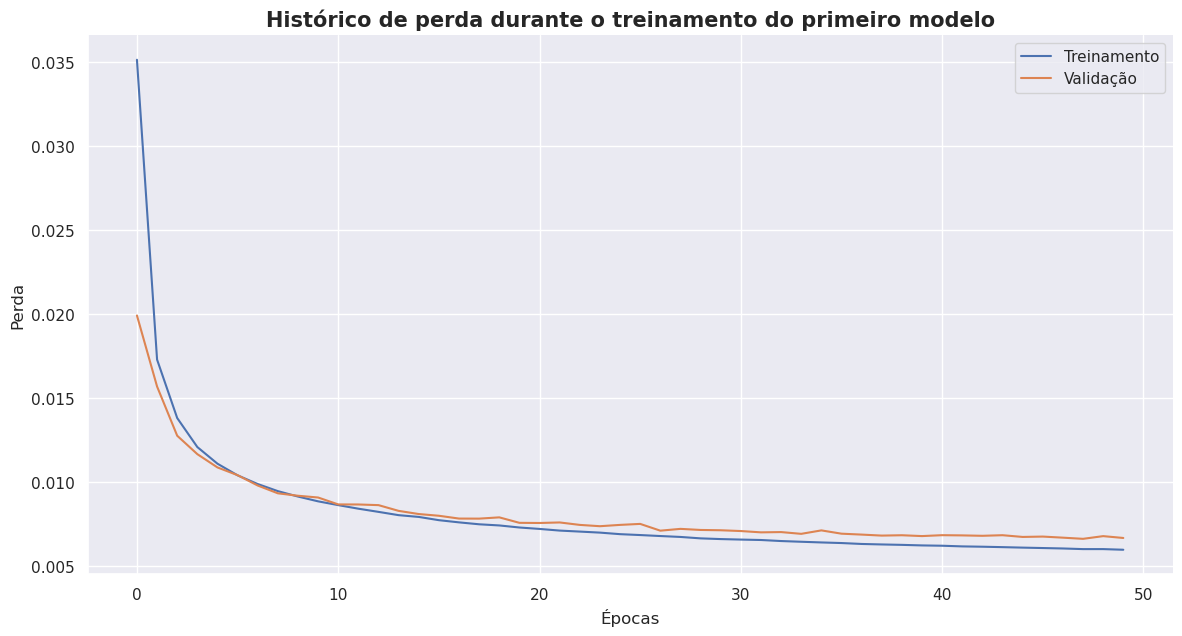

In [17]:
# Plotando o histórico de perda
plt.figure(figsize=(14,7))
plt.plot(quarto_historico.history['loss'], label='Treinamento')
plt.plot(quarto_historico.history['val_loss'], label='Validação')
plt.title('Histórico de perda durante o treinamento do primeiro modelo', fontsize=15, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

### Reconstrução VAE do segundo modelo no segundo dataset

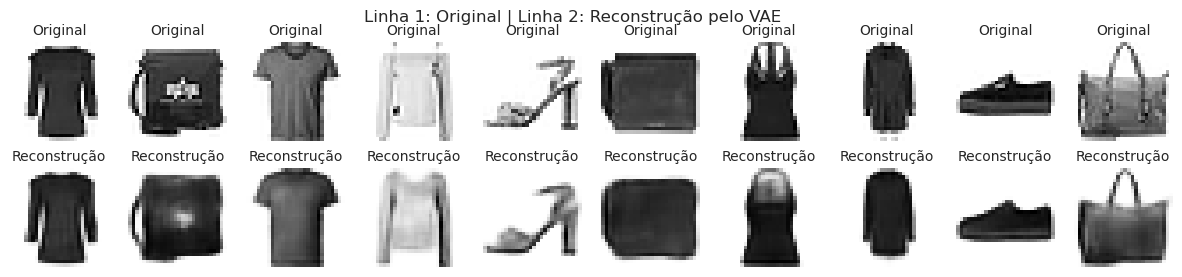

In [18]:
segundo_vae.reconstrucoes(X_validacao_2, n_imagens=10)

O segundo modelo apresentou um desempenho melhor no Fashion MNIST. As reconstruções das imagens foram significativamente mais precisas, com menos distorções visíveis, o que indica que o encoder foi capaz de extrair informações mais relevantes das imagens. A separação dos clusters no espaço latente também melhorou, com as diferentes classes se agrupando de maneira mais distinta. Embora ainda haja alguma sobreposição, o modelo mostrou uma capacidade mais avançada de organizar os dados em um espaço latente mais estruturado.